## Step 2: Scouting Research Candidates

Decision whether or not to pursue a research item

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

from components.agents.scout_agent import scout_batch

Load Research Items

In [2]:
df = pd.read_csv("../data/research_items.csv")

provider_counts = df['provider'].value_counts()
print("Absolute counts:")
print(provider_counts)
print("\nNormalized (proportions):")
print(df['provider'].value_counts(normalize=True))

Absolute counts:
provider
arxiv        4044
openai        649
anthropic     509
exa           393
Name: count, dtype: int64

Normalized (proportions):
provider
arxiv        0.722788
openai       0.115996
anthropic    0.090974
exa          0.070241
Name: proportion, dtype: float64


Select items that have not yet been looked at

In [3]:
pending = df[df["scout_decision"].isna() | df["scout_reasoning"].str.startswith("ERROR:", na=False)]

# Collect scout items
items_to_scout = pending.to_dict("records")
print(f"Number of items to scout: {len(items_to_scout)}")

Number of items to scout: 761


Run Scouting

In [4]:
decisions = await scout_batch(
    items=items_to_scout, 
    batch_size=250
)

2025-12-30 11:33:56,764 - components.agents.scout_agent - INFO - Processing batch 1/4 (250 items)
Scout batch 1/4:   0%|          | 1/250 [00:06<28:18,  6.82s/it]2025-12-30 11:34:03,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-30 11:34:03,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-30 11:34:03,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
Scout batch 1/4:   2%|▏         | 4/250 [00:07<05:34,  1.36s/it]2025-12-30 11:34:03,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-30 11:34:04,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
Scout batch 1/4:   2%|▏         | 6/250 [00:07<03:19,  1.22it/s]2025-12-30 11:34:04,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-30 11:34:04,139 - 

Update DataFrame

In [5]:
for i, (idx, row) in enumerate(pending.iterrows()):
    df.loc[idx, "scout_decision"] = "pursue" if decisions[i].pursue else "discard"
    df.loc[idx, "scout_confidence"] = decisions[i].confidence
    df.loc[idx, "scout_reasoning"] = decisions[i].reasoning
    df.loc[idx, "scouted_at"] = datetime.now().isoformat()

In [6]:
df['scout_decision'].value_counts(dropna=False)

scout_decision
pursue     3280
discard    2315
Name: count, dtype: int64

Save back to DF

In [7]:
df.to_csv("../data/research_items.csv", index=False)

Check some pursue vs discard items

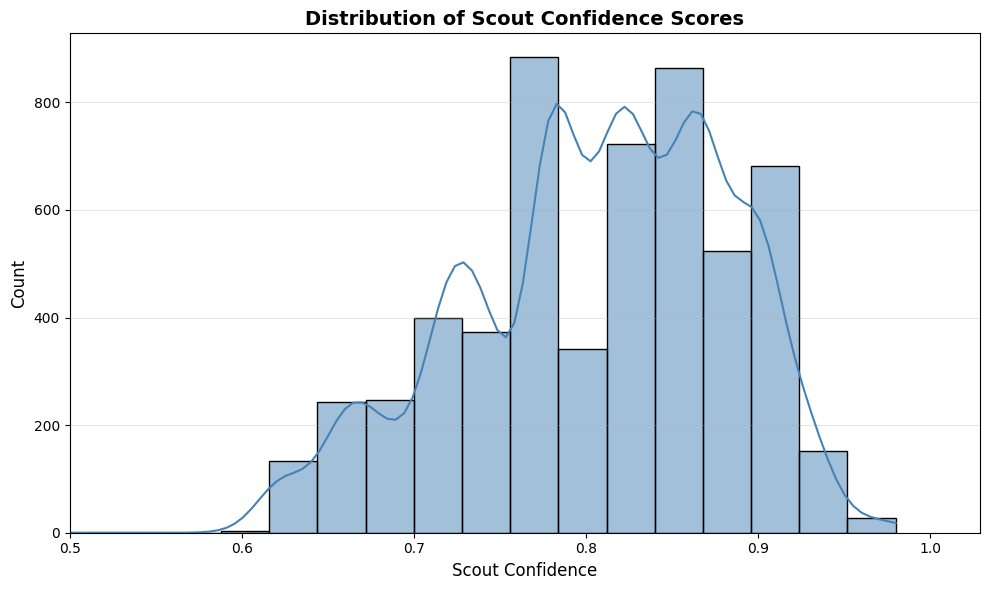

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['scout_confidence'], bins=35, kde=True, ax=ax, color='steelblue')
ax.set_xlabel('Scout Confidence', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Scout Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlim(left=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()